In [106]:
import torch
import torch.nn as nn
from torch.nn import init
from torch.nn import functional as F
from torchsummary import summary
import torchvision
import torchvision.transforms as T
from torchvision.utils import save_image
from torchvision.transforms import functional as F_vision
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import sampler
import torchvision.datasets as dset
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
from PIL import Image
from livelossplot import PlotLosses
from tqdm import tqdm
import cv2
from torchvision.models import resnet50, ResNet50_Weights

import os
import math
import random
import time
import shutil
import itertools

In [2]:
dataset_path = "./datasets"
saved_models_path = "./model.pth"

domain_sets = [
    "horse2zebra", 
    "monet2photo"
]

cycle_gan_variations = [
    {
        "id": 0,
        "domain_set": "horse2zebra",
        "architecture_params": {
            "image_size": 256,
            "number_of_residual_blocks": 9,
            "normalizaion_level": "instance",
            "disciminator_output_shape": (1, 1)
        },
        "training_params": {
            "number_of_epochs": 200,
            "batch_size": 8,
            "optimizer": "Adam",
            "learning_rate": 0.0002,
            "mixed_precision": True
        }
    },
    {
        "id": 1,
        "domain_set": "horse2zebra",
        "architecture_params": {
            "image_size": 256,
            "number_of_residual_blocks": 9,
            "normalizaion_level": "instance",
            "disciminator_output_shape": (15, 15)
        },
        "training_params": {
            "number_of_epochs": 200,
            "batch_size": 8,
            "optimizer": "Adam",
            "learning_rate": 0.0002,
            "mixed_precision": True
        }
    },
    {
        "id": 2,
        "domain_set": "horse2zebra",
        "architecture_params": {
            "image_size": 256,
            "number_of_residual_blocks": 9,
            "normalizaion_level": "instance",
            "disciminator_output_shape": (30, 30)
        },
        "training_params": {
            "number_of_epochs": 200,
            "batch_size": 8,
            "optimizer": "Adam",
            "learning_rate": 0.0002,
            "mixed_precision": True
        }
    },
    {
        "id": 3,
        "domain_set": "horse2zebra",
        "architecture_params": {
            "image_size": 256,
            "number_of_residual_blocks": 9,
            "normalizaion_level": "batch",
            "disciminator_output_shape": (30, 30)
        },
        "training_params": {
            "number_of_epochs": 200,
            "batch_size": 8,
            "optimizer": "Adam",
            "learning_rate": 0.0002,
            "mixed_precision": True
        }
    },
    {
        "id": 4,
        "domain_set": "monet2photo",
        "architecture_params": {
            "image_size": 256,
            "number_of_residual_blocks": 9,
            "normalizaion_level": "instance",
            "disciminator_output_shape": (15, 15)
        },
        "training_params": {
            "number_of_epochs": 200,
            "batch_size": 8,
            "optimizer": "Adam",
            "learning_rate": 0.0002,
            "mixed_precision": True
        }
    }
]

In [3]:
def clean_dataset(dataset_path, domain_sets):
    for domain_set in domain_sets:
        dataset_path = os.path.join(dataset_path, domain_set)
        for folder in ["trainA", "trainB", "testA", "testB"]:
            for (root, dirs, files) in os.walk(os.path.join(dataset_path, folder)):
                for d in dirs:
                    if d.startswith('.'):
                        dir_path = os.path.join(root, d)
                        shutil.rmtree(dir_path)

clean_dataset(dataset_path, domain_sets)

In [4]:
class DomainSet(Dataset):
    def __init__(self, source_path, train=True, transform=None):
        self.train = train
        self.transform = transform
        
        self.images_a_path = os.path.join(source_path, "trainA" if self.train else "testA")
        self.images_b_path = os.path.join(source_path, "trainB" if self.train else "testB")
        
        self.images_a = sorted(os.listdir(self.images_a_path))
        self.images_b = sorted(os.listdir(self.images_b_path))

    def __len__(self):
        return max(len(self.images_a), len(self.images_b))

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()
            
        image_a = Image.open(os.path.join(self.images_a_path, self.images_a[index % len(self.images_a)]))
        image_b = Image.open(os.path.join(self.images_b_path, self.images_b[index % len(self.images_b)]))

        # Convert grayscale images to rgb
        if image_a.mode != "RGB":
            image_a = self.__convert_to_rgb__(image_a)
        if image_b.mode != "RGB":
            image_b = self.__convert_to_rgb__(image_b)
            
        return {"image_a": self.transform(image_a), "image_b": self.transform(image_b)}

    def __convert_to_rgb__(self, image):
        rgb_image = Image.new("RGB", image.size)
        rgb_image.paste(image)
        return rgb_image

In [5]:
class ReplayBuffer:
    def __init__(self, max_size=50):
        assert max_size > 0
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0, 1) > 0.5:
                    i = random.randint(0, self.max_size - 1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return torch.cat(to_return)

In [6]:
class Norm2d(nn.Module):
    def __init__(self, normalizaion_level, in_features):
        super(Norm2d, self).__init__()
        if normalizaion_level == 'instance':
            self.norm_layer = nn.InstanceNorm2d(in_features)
        if normalizaion_level == 'batch':
            self.norm_layer = nn.BatchNorm2d(in_features)
    
    def forward(self, x):
        return self.norm_layer(x)

In [7]:
class ResidualBlock(nn.Module):
    def __init__(self, normalizaion_level, in_features):
        super(ResidualBlock, self).__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=0),
            Norm2d(normalizaion_level, in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=0),
            Norm2d(normalizaion_level, in_features),
        )

    def forward(self, x):
        return (x + self.block(x))

In [8]:
class Generator(nn.Module):
    def __init__(self, number_of_residual_blocks, normalizaion_level):
        super(Generator, self).__init__()
        downsampling_layers = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(3, 64, 7, stride=1, padding=0),
            Norm2d(normalizaion_level, 64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            Norm2d(normalizaion_level, 128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            Norm2d(normalizaion_level, 256),
            nn.ReLU(inplace=True),
        ]
        residual_layers = []
        upsampling_layers = [
            nn.ConvTranspose2d(256, 128, 3, stride=2, padding=1, output_padding=1),
            Norm2d(normalizaion_level, 128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, 3, stride=2, padding=1, output_padding=1),
            Norm2d(normalizaion_level, 64),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(64, 3, 7, stride=1, padding=0),
            nn.Tanh()
        ]
        for _ in range(number_of_residual_blocks):
            residual_layers += [ResidualBlock(normalizaion_level, in_features=256)]
        model = downsampling_layers + residual_layers + upsampling_layers
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

In [9]:
class Discriminator(nn.Module):
    def __init__(self, image_size, normalizaion_level, disciminator_output_shape):
        super(Discriminator, self).__init__()
        self.image_size = image_size
        self.disciminator_output_shape = disciminator_output_shape
        if self.disciminator_output_shape == (15, 15):
            self.conv_stride = 2
        elif self.disciminator_output_shape == (1, 1) or self.disciminator_output_shape == (30, 30):
            self.conv_stride = 1
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            Norm2d(normalizaion_level, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            Norm2d(normalizaion_level, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=self.conv_stride, padding=1),
            Norm2d(normalizaion_level, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, stride=1, padding=1),
        )

    def forward(self, x):
        x = self.model(x)
        if self.disciminator_output_shape == (1, 1):
            x = F.avg_pool2d(x, x.size()[2:])
            x = torch.flatten(x, 1)
        return x

In [11]:
class Classifier(nn.Module):
    def __init__(self, normalization_level='instance'):
        super(Classifier, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, stride=2, padding=1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),
            Norm2d(normalization_level, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, stride=2, padding=1),
            Norm2d(normalization_level, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, stride=2, padding=1),
            Norm2d(normalization_level, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 512, 4, stride=1, padding=1),
            nn.AvgPool2d(15),
            nn.Flatten(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [95]:
class DomainClassifier:
    def __init__(self, domain_set, dataset_path, saved_models_path):
        self.saved_models_path = saved_models_path
        self.domain_set = domain_set
        self.domain_set_path = os.path.join(dataset_path, domain_set)
        self.initialize_architecture()

        self.initialize_architecture()
        self.initialize_misc_params()
        self.initialize_weights()
        self.initialize_training_params()
            
    def save_pre_trained_weights(self):
        if os.path.exists(self.saved_models_path):
            saved_models = torch.load(self.saved_models_path)
            if "domain_classifier" in saved_models.keys():
                if self.domain_set in saved_models["domain_classifier"].keys():
                    if "pre_trained_weights" not in saved_models["domain_classifier"][self.domain_set]:
                        saved_models["domain_classifier"][self.domain_set]["pre_trained_weights"] = self.classifier.state_dict()
                        torch.save(saved_models, self.saved_models_path)
                else:
                    saved_models["domain_classifier"][self.domain_set] = {
                        "pre_trained_weights": self.classifier.state_dict()
                    }
                    torch.save(saved_models, self.saved_models_path)
            else:
                saved_models["domain_classifier"] = {
                    self.domain_set: {
                        "pre_trained_weights": self.classifier.state_dict()
                    }
                }
                torch.save(saved_models, self.saved_models_path)
        else:
            saved_models = {
                "domain_classifier": {
                    self.domain_set: {
                        "pre_trained_weights": self.classifier.state_dict()
                    }
                }
            }
            torch.save(saved_models, self.saved_models_path)
            
    def load_pre_trained_weights(self):
        if os.path.exists(self.saved_models_path):
            saved_models = torch.load(self.saved_models_path)
            if "domain_classifier" in saved_models.keys():
                if self.domain_set in saved_models["domain_classifier"].keys():
                    if "pre_trained_weights" in saved_models["domain_classifier"][self.domain_set]:
                        return saved_models["domain_classifier"][self.domain_set]["pre_trained_weights"]
        return None
            
    def initialize_architecture(self):
        self.classifier = Classifier()
        
        trainable_model_parameters = filter(lambda p: p.requires_grad, self.classifier.parameters())
        self.num_trainable_model_parameters = sum([np.prod(p.size()) for p in trainable_model_parameters])
        
    def initialize_weights(self):
        pre_trained_weights = self.load_pre_trained_weights()
        self.classifier = self.classifier.to(self.device)
        if pre_trained_weights != None:
            self.classifier.load_state_dict(pre_trained_weights)
            
    def initialize_training_params(self):
        b1 = 0.5
        b2 = 0.999
        learning_rate = 0.0001

        self.number_of_epochs = 50
        self.batch_size = 24

        self.loss_classifier = nn.CrossEntropyLoss()
        self.optimizer_classifier = torch.optim.Adam(self.classifier.parameters(), lr=learning_rate, betas=(b1, b2))
        
    def initialize_misc_params(self):
        self.device = 'cuda'
            
    def trainer(self):
        for epoch in range(self.number_of_epochs):
            self.train()
            test_loss, test_accuracy = self.evaluate()
            checkpoint_params = {
                "test_loss": test_loss,
                "test_accuracy": test_accuracy
            }
            yield checkpoint_params
            
    def train(self):
        train_dataloader = DataLoader(
            DomainSet(self.domain_set_path, train=True, transform=T.ToTensor()),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=8
        )
        for batch_index, batch in enumerate(train_dataloader):
            self.classifier.train()
            
            image_a = batch["image_a"].to(self.device)
            image_b = batch["image_b"].to(self.device)
            images = torch.concatenate((image_a, image_b), axis=0)
            
            label_a = torch.Tensor([0]).repeat(image_a.shape[0]).to(self.device)
            label_b = torch.Tensor([1]).repeat(image_b.shape[0]).to(self.device)
            labels = torch.concatenate((label_a, label_b), axis=0)
            
            logits = self.classifier(images)
            
            loss = self.loss_classifier(logits, labels.long())
            
            self.optimizer_classifier.zero_grad()
            loss.backward()
            self.optimizer_classifier.step()
                    
    def evaluate(self):
        test_dataloader = DataLoader(
            DomainSet(self.domain_set_path, train=False, transform=T.ToTensor()),
            batch_size=1,
            shuffle=False,
            num_workers=1
        )
        test_loss = 0
        test_accuracy = 0
        for batch_index, batch in enumerate(test_dataloader):
            self.classifier.eval()
              
            with torch.no_grad():
                image_a = batch["image_a"].to(self.device)
                image_b = batch["image_b"].to(self.device)
                images = torch.concatenate((image_a, image_b), axis=0)

                label_a = torch.Tensor([0]).repeat(image_a.shape[0]).to(self.device)
                label_b = torch.Tensor([1]).repeat(image_b.shape[0]).to(self.device)
                labels = torch.concatenate((label_a, label_b), axis=0)

                logits = self.classifier(images)
                predicted = torch.argmax(logits, dim=1)

                loss = self.loss_classifier(logits, labels.long())
                accuracy = predicted.eq(labels.view_as(predicted)).float().mean()

                test_loss += loss.item()
                test_accuracy += accuracy.item()
            
        test_loss = test_loss / len(test_dataloader.dataset)
        test_accuracy = test_accuracy / len(test_dataloader.dataset)
        return (test_loss, test_accuracy)   
    
    def get_confidence(self, images):
        self.classifier.eval()
        with torch.no_grad():
            logits = self.classifier(images)
            print(logits.shape)
            confidence = F.softmax(logits.float(), dim=1)
        return confidence
    
    def predict(self, images):
        self.classifier.eval()
        with torch.no_grad():
            logits = self.classifier(images)
            predicted = torch.argmax(logits, dim=1)
        return predicted
    
    def close(self):
        pre_trained_weights = self.load_pre_trained_weights()
        if pre_trained_weights == None:
            self.save_pre_trained_weights()
        del self.optimizer_classifier
        del self.classifier
        torch.cuda.empty_cache()

In [54]:
class CycleGAN:
    def __init__(self, params, dataset_path, saved_models_path):
        self.model_id = params["id"]
        self.saved_models_path = saved_models_path
        self.domain_set_path = os.path.join(dataset_path, params["domain_set"])

        self.initialize_domain_classifier(params["domain_set"], dataset_path, saved_models_path)
        self.initialize_architecture(self.model_id, params["architecture_params"])
        self.initialize_weights(self.model_id)
        self.initialize_training_params(self.model_id, params["training_params"])
            
    def save_architecture_params(self, model_id, architecture_params):
        if os.path.exists(self.saved_models_path):
            saved_models = torch.load(self.saved_models_path)
            if "cycle_gan" in saved_models.keys():
                if model_id in saved_models["cycle_gan"].keys():
                    if "architecture_params" not in saved_models["cycle_gan"][model_id]:
                        saved_models["cycle_gan"][model_id]["architecture_params"] = architecture_params
                        torch.save(saved_models, self.saved_models_path)
                else:
                    saved_models["cycle_gan"][model_id] = {
                        "architecture_params": architecture_params
                    }
                    torch.save(saved_models, self.saved_models_path)
            else:
                saved_models["cycle_gan"] = {
                    model_id: {
                        "architecture_params": architecture_params
                    }
                }
                torch.save(saved_models, self.saved_models_path)
        else:
            saved_models = {
                "cycle_gan": {
                    model_id: {
                        "architecture_params": architecture_params
                    }
                }
            }
            torch.save(saved_models, self.saved_models_path)
            
    def save_training_params(self, model_id, training_params):
        if os.path.exists(self.saved_models_path):
            saved_models = torch.load(self.saved_models_path)
            if "cycle_gan" in saved_models.keys():
                if model_id in saved_models["cycle_gan"].keys():
                    if "training_params" not in saved_models["cycle_gan"][model_id]:
                        saved_models["cycle_gan"][model_id]["training_params"] = training_params
                        torch.save(saved_models, self.saved_models_path)
                else:
                    saved_models["cycle_gan"][model_id] = {
                        "training_params": training_params
                    }
                    torch.save(saved_models, self.saved_models_path)
            else:
                saved_models["cycle_gan"] = {
                    model_id: {
                        "training_params": training_params
                    }
                }
                torch.save(saved_models, self.saved_models_path)
        else:
            saved_models = {
                "cycle_gan": {
                    model_id: {
                        "training_params": training_params
                    }
                }
            }
            torch.save(saved_models, self.saved_models_path)
            
    def save_checkpoint(self, model_id, checkpoint_id, params):
        checkpoint_path = os.path.join("./checkpoints", f"cyclegan_{model_id}")
        if os.path.exists(checkpoint_path):
            checkpoint_path = os.path.join(checkpoint_path, f"checkpoint_{checkpoint_id}.pth")
            torch.save(params, checkpoint_path)
        else:
            os.mkdir(checkpoint_path)
            checkpoint_path = os.path.join(checkpoint_path, f"checkpoint_{checkpoint_id}.pth")
            torch.save(params, checkpoint_path)
            
    def load_checkpoint(self, model_id, checkpoint_id):
        checkpoint_path = os.path.join("./checkpoints", f"cyclegan_{model_id}")
        if os.path.exists(checkpoint_path):
            checkpoint_path = os.path.join(checkpoint_path, f"checkpoint_{checkpoint_id}.pth")
            if os.path.exists(checkpoint_path):
                params = torch.load(checkpoint_path)
                self.d_a.load_state_dict(params["weights"]["d_a"])
                self.d_b.load_state_dict(params["weights"]["d_b"])
                self.g_ab.load_state_dict(params["weights"]["g_ab"])
                self.g_ba.load_state_dict(params["weights"]["g_ba"])
                return params
        return None
            
    def save_pre_trained_weights(self):
        if os.path.exists(self.saved_models_path):
            saved_models = torch.load(self.saved_models_path)
            if "cycle_gan" in saved_models.keys():
                if self.model_id in saved_models["cycle_gan"].keys():
                    if "pre_trained_weights" not in saved_models["cycle_gan"][self.model_id]:
                        saved_models["cycle_gan"][self.model_id]["pre_trained_weights"] = {
                            "d_a": self.d_a.state_dict(),
                            "d_b": self.d_b.state_dict(),
                            "g_ab": self.g_ab.state_dict(),
                            "g_ba": self.g_ba.state_dict()
                        }
                        torch.save(saved_models, self.saved_models_path)
                else:
                    saved_models["cycle_gan"][self.model_id] = {
                        "pre_trained_weights": {
                            "d_a": self.d_a.state_dict(),
                            "d_b": self.d_b.state_dict(),
                            "g_ab": self.g_ab.state_dict(),
                            "g_ba": self.g_ba.state_dict()
                        }
                    }
                    torch.save(saved_models, self.saved_models_path)
            else:
                saved_models["cycle_gan"] = {
                    self.model_id: {
                        "pre_trained_weights": {
                            "d_a": self.d_a.state_dict(),
                            "d_b": self.d_b.state_dict(),
                            "g_ab": self.g_ab.state_dict(),
                            "g_ba": self.g_ba.state_dict()
                        }
                    }
                }
                torch.save(saved_models, self.saved_models_path)
        else:
            saved_models = {
                "cycle_gan": {
                    self.model_id: {
                        "pre_trained_weights": {
                            "d_a": self.d_a.state_dict(),
                            "d_b": self.d_b.state_dict(),
                            "g_ab": self.g_ab.state_dict(),
                            "g_ba": self.g_ba.state_dict()
                        }
                    }
                }
            }
            torch.save(saved_models, self.saved_models_path)
            
    def load_pre_trained_weights(self):
        if os.path.exists(self.saved_models_path):
            saved_models = torch.load(self.saved_models_path)
            if "cycle_gan" in saved_models.keys():
                if self.model_id in saved_models["cycle_gan"].keys():
                    if "pre_trained_weights" in saved_models["cycle_gan"][self.model_id]:
                        return saved_models["cycle_gan"][self.model_id]["pre_trained_weights"]
        return None
    
    def load_new_weights(self, m):
        classname = m.__class__.__name__
        if classname.find("Conv") != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
            if hasattr(m, "bias") and m.bias is not None:
                nn.init.constant_(m.bias.data, 0.0)
        elif classname.find("BatchNorm2d") != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0.0)
            
    def initialize_architecture(self, model_id, architecture_params):
        self.save_architecture_params(model_id, architecture_params)
        
        self.device = 'cuda'
        
        self.d_a = Discriminator(
            architecture_params["image_size"], 
            architecture_params["normalizaion_level"],
            architecture_params["disciminator_output_shape"]
        )
        self.d_b =  Discriminator(
            architecture_params["image_size"], 
            architecture_params["normalizaion_level"],
            architecture_params["disciminator_output_shape"]
        )
        self.g_ab = Generator(
            architecture_params["number_of_residual_blocks"], 
            architecture_params["normalizaion_level"]
        )
        self.g_ba = Generator(
            architecture_params["number_of_residual_blocks"], 
            architecture_params["normalizaion_level"]
        )
        
        trainable_model_parameters = filter(lambda p: p.requires_grad, itertools.chain(
            self.d_a.parameters(), 
            self.d_b.parameters(), 
            self.g_ab.parameters(), 
            self.g_ba.parameters()
        ))
        self.num_trainable_model_parameters = sum([np.prod(p.size()) for p in trainable_model_parameters])
        
    def initialize_weights(self, model_id):
        pre_trained_weights = self.load_pre_trained_weights()
        if pre_trained_weights == None:
            self.d_a = self.d_a.apply(self.load_new_weights).to(self.device)
            self.d_b = self.d_b.apply(self.load_new_weights).to(self.device)
            self.g_ab = self.g_ab.apply(self.load_new_weights).to(self.device)
            self.g_ba = self.g_ba.apply(self.load_new_weights).to(self.device)
        else:
            self.d_a = self.d_a.to(self.device)
            self.d_a.load_state_dict(pre_trained_weights["d_a"])
            self.d_b = self.d_b.to(self.device)
            self.d_b.load_state_dict(pre_trained_weights["d_b"])
            self.g_ab = self.g_ab.to(self.device)
            self.g_ab.load_state_dict(pre_trained_weights["g_ab"])
            self.g_ba = self.g_ba.to(self.device)
            self.g_ba.load_state_dict(pre_trained_weights["g_ba"])
            
    def initialize_domain_classifier(self, domain_set, dataset_path, saved_models_path):
        self.domain_classifier = DomainClassifier(domain_set, dataset_path, saved_models_path)
            
    def initialize_training_params(self, model_id, training_params):
        pre_trained_weights = self.load_pre_trained_weights()
        if pre_trained_weights == None:
            self.save_training_params(model_id, training_params)
            
        self.higher_precision_dtype = torch.float
        self.lower_precision_dtype = torch.float16
        self.scaler = torch.cuda.amp.GradScaler()
        self.fake_a_buffer = ReplayBuffer()
        self.fake_b_buffer = ReplayBuffer()

        self.number_of_epochs = training_params["number_of_epochs"]
        self.batch_size = training_params["batch_size"]
        self.mixed_precision_training = training_params["mixed_precision"]
        self.learning_rate = training_params["learning_rate"]
        
        b1 = 0.5
        b2 = 0.999
        
        self.optimizer_g = torch.optim.Adam(
            itertools.chain(self.g_ab.parameters(), self.g_ba.parameters()), lr=self.learning_rate, betas=(b1, b2)
        )
        self.optimizer_d_a = torch.optim.Adam(self.d_a.parameters(), lr=self.learning_rate, betas=(b1, b2))
        self.optimizer_d_b = torch.optim.Adam(self.d_b.parameters(), lr=self.learning_rate, betas=(b1, b2))

                    
    def trainer(self):
        for epoch in range(self.number_of_epochs):
            checkpoint_params = self.load_checkpoint(self.model_id, epoch)
            if checkpoint_params is None:
                train_g_loss, train_d_loss = self.train()
                test_g_loss, test_d_loss, test_g_accuracy = self.evaluate()
                checkpoint_params = {
                    "train_g_loss": train_g_loss,
                    "train_d_loss": train_d_loss,
                    "test_g_loss": test_g_loss,
                    "test_d_loss": test_d_loss,
                    "test_g_accuracy": test_g_accuracy,
                    "weights": {
                        "d_a": self.d_a.state_dict(),
                        "d_b": self.d_b.state_dict(),
                        "g_ab": self.g_ab.state_dict(),
                        "g_ba": self.g_ba.state_dict()
                    }
                }
                self.save_checkpoint(self.model_id, epoch, checkpoint_params)
            del checkpoint_params["weights"]
            yield checkpoint_params
            
    def train(self):
        train_dataloader = DataLoader(
            DomainSet(self.domain_set_path, train=True, transform=T.ToTensor()),
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=8
        )
        running_train_g_loss = 0
        running_train_d_loss = 0
        for batch_index, batch in enumerate(train_dataloader):
            real_a = batch["image_a"].to(self.device)
            real_b = batch["image_b"].to(self.device)

            (fake_a, fake_b, train_g_loss) = self.train_generators(real_a, real_b)
            running_train_g_loss += train_g_loss
            train_d_loss = self.train_discriminators(real_a, real_b, fake_a, fake_b)
            running_train_d_loss += train_d_loss
            if self.mixed_precision_training:
                self.scaler.update()
        train_g_loss = running_train_g_loss / len(train_dataloader.dataset)
        train_d_loss = running_train_d_loss / len(train_dataloader.dataset)
        return (train_g_loss, train_d_loss)   
                    
    def evaluate(self):
        test_dataloader = DataLoader(
            DomainSet(self.domain_set_path, train=False, transform=T.ToTensor()),
            batch_size=1,
            shuffle=False,
            num_workers=1
        )
        self.mixed_precision_training = False
        running_test_g_loss = 0
        running_test_d_loss = 0
        running_test_g_accuracy = 0
        for batch_idx, batch in enumerate(test_dataloader):        
            with torch.no_grad():
                real_a = batch["image_a"].to(self.device)
                real_b = batch["image_b"].to(self.device)
                
                (fake_a, fake_b, test_g_loss, test_g_accuracy) = self.evaluate_generators(real_a, real_b)
                running_test_g_loss += test_g_loss
                running_test_g_accuracy += test_g_accuracy
                test_d_loss = self.evaluate_discriminators(real_a, real_b, fake_a, fake_b)
                running_test_d_loss += test_d_loss
        test_g_loss = running_test_g_loss / len(test_dataloader.dataset)
        test_d_loss = running_test_d_loss / len(test_dataloader.dataset)
        test_g_accuracy = running_test_g_accuracy / len(test_dataloader.dataset)
        return (test_g_loss, test_d_loss, test_g_accuracy)   
            
    def train_generators(self, real_a, real_b):
        self.g_ab.train()
        self.g_ba.train()
        self.optimizer_g.zero_grad()

        if self.mixed_precision_training:
            with torch.autocast(device_type=self.device, dtype=self.lower_precision_dtype):

                fake_a = self.g_ba(real_b)
                fake_b = self.g_ab(real_a)

                identity_a = self.g_ba(real_a)
                identity_b = self.g_ab(real_b)

                fake_logits_a = self.d_a(fake_a)
                fake_logits_b = self.d_b(fake_b)

                cycle_a = self.g_ba(fake_b)
                cycle_b = self.g_ab(fake_a)

                loss_g = self.generator_loss(
                    self.lower_precision_dtype,
                    real_a,
                    real_b,
                    identity_a,
                    identity_b,
                    fake_logits_a,
                    fake_logits_b,
                    cycle_a,
                    cycle_b
                )
            self.scaler.scale(loss_g).backward()
            self.scaler.step(self.optimizer_g)
        else:
            fake_a = self.g_ba(real_b)
            fake_b = self.g_ab(real_a)

            identity_a = self.g_ba(real_a)
            identity_b = self.g_ab(real_b)

            fake_logits_a = self.d_a(fake_a)
            fake_logits_b = self.d_b(fake_b)

            cycle_a = self.g_ba(fake_b)
            cycle_b = self.g_ab(fake_a)

            loss_g = self.generator_loss(
                self.higher_precision_dtype,
                real_a,
                real_b,
                identity_a,
                identity_b,
                fake_logits_a,
                fake_logits_b,
                cycle_a,
                cycle_b
            )

            loss_g.backward()
            self.optimizer_g.step()
            
        train_g_loss = loss_g.item() * self.batch_size
        return (fake_a, fake_b, train_g_loss)
            
    def train_discriminators(self, real_a, real_b, fake_a, fake_b):
        self.d_a.train()
        self.optimizer_d_a.zero_grad()
        
        if self.mixed_precision_training:
            with torch.autocast(device_type=self.device, dtype=self.lower_precision_dtype):
                real_logits_a = self.d_a(real_a)
                buffered_fake_a = self.fake_a_buffer.push_and_pop(fake_a)
                fake_logits_a = self.d_a(buffered_fake_a.detach())

                loss_d_a = self.discriminator_loss(
                    self.lower_precision_dtype,
                    real_logits_a,
                    fake_logits_a
                )
            self.scaler.scale(loss_d_a).backward()
            self.scaler.step(self.optimizer_d_a)
        else:
            real_logits_a = self.d_a(real_a)
            buffered_fake_a = self.fake_a_buffer.push_and_pop(fake_a)
            fake_logits_a = self.d_a(buffered_fake_a.detach())

            loss_d_a = self.discriminator_loss(
                self.higher_precision_dtype,
                real_logits_a,
                fake_logits_a
            )
            loss_d_a.backward()
            self.optimizer_d_a.step()
            
        self.d_b.train()
        self.optimizer_d_b.zero_grad()
        
        if self.mixed_precision_training:
            with torch.autocast(device_type=self.device, dtype=self.lower_precision_dtype):
                real_logits_b = self.d_b(real_b)
                buffered_fake_b = self.fake_b_buffer.push_and_pop(fake_b)
                fake_logits_b = self.d_b(buffered_fake_b.detach())

                loss_d_b = self.discriminator_loss(
                    self.lower_precision_dtype,
                    real_logits_b,
                    fake_logits_b
                )
            self.scaler.scale(loss_d_b).backward()
            self.scaler.step(self.optimizer_d_b)
        else:
            real_logits_b = self.d_b(real_b)
            buffered_fake_b = self.fake_b_buffer.push_and_pop(fake_b)
            fake_logits_b = self.d_b(buffered_fake_b.detach())

            loss_d_b = self.discriminator_loss(
                self.higher_precision_dtype,
                real_logits_b,
                fake_logits_b
            )
            loss_d_b.backward()
            self.optimizer_d_b.step()
        
        train_d_loss = ((loss_d_a + loss_d_b) / 2).item() * self.batch_size
        return train_d_loss
        
            
    def evaluate_generators(self, real_a, real_b):
        self.g_ab.eval()
        self.g_ba.eval()

        if self.mixed_precision_training:
            with torch.autocast(device_type=self.device, dtype=self.lower_precision_dtype):
                fake_a = self.g_ba(real_b)
                fake_b = self.g_ab(real_a)

                identity_a = self.g_ba(real_a)
                identity_b = self.g_ab(real_b)

                fake_logits_a = self.d_a(fake_a)
                fake_logits_b = self.d_b(fake_b)

                cycle_a = self.g_ba(fake_b)
                cycle_b = self.g_ab(fake_a)
                
                loss_g = self.generator_loss(
                    self.lower_precision_dtype,
                    real_a,
                    real_b,
                    identity_a,
                    identity_b,
                    fake_logits_a,
                    fake_logits_b,
                    cycle_a,
                    cycle_b
                )
        else:
            fake_a = self.g_ba(real_b)
            fake_b = self.g_ab(real_a)

            identity_a = self.g_ba(real_a)
            identity_b = self.g_ab(real_b)

            fake_logits_a = self.d_a(fake_a)
            fake_logits_b = self.d_b(fake_b)

            cycle_a = self.g_ba(fake_b)
            cycle_b = self.g_ab(fake_a)

            loss_g = self.generator_loss(
                self.higher_precision_dtype,
                real_a,
                real_b,
                identity_a,
                identity_b,
                fake_logits_a,
                fake_logits_b,
                cycle_a,
                cycle_b
            )
            
        test_g_accuracy = self.generator_accuracy(fake_a, fake_b).item()
        test_g_loss = loss_g.item()
        return (fake_a, fake_b, test_g_loss, test_g_accuracy)
            
    def evaluate_discriminators(self, real_a, real_b, fake_a, fake_b):
        self.d_a.eval()
        
        if self.mixed_precision_training:
            with torch.autocast(device_type=self.device, dtype=self.lower_precision_dtype):
                real_logits_a = self.d_a(real_a)
                buffered_fake_a = self.fake_a_buffer.push_and_pop(fake_a)
                fake_logits_a = self.d_a(buffered_fake_a.detach())

                loss_d_a = self.discriminator_loss(
                    self.lower_precision_dtype,
                    real_logits_a,
                    fake_logits_a
                )
        else:
            real_logits_a = self.d_a(real_a)
            buffered_fake_a = self.fake_a_buffer.push_and_pop(fake_a)
            fake_logits_a = self.d_a(buffered_fake_a.detach())

            loss_d_a = self.discriminator_loss(
                self.higher_precision_dtype,
                real_logits_a,
                fake_logits_a
            )
            
        self.d_b.eval()
        
        if self.mixed_precision_training:
            with torch.autocast(device_type=self.device, dtype=self.lower_precision_dtype):
                real_logits_b = self.d_b(real_b)
                buffered_fake_b = self.fake_b_buffer.push_and_pop(fake_b)
                fake_logits_b = self.d_b(buffered_fake_b.detach())

                loss_d_b = self.discriminator_loss(
                    self.lower_precision_dtype,
                    real_logits_b,
                    fake_logits_b
                )
        else:
            real_logits_b = self.d_b(real_b)
            buffered_fake_b = self.fake_b_buffer.push_and_pop(fake_b)
            fake_logits_b = self.d_b(buffered_fake_b.detach())

            loss_d_b = self.discriminator_loss(
                self.higher_precision_dtype,
                real_logits_b,
                fake_logits_b
            )
        
        test_d_loss = ((loss_d_a + loss_d_b) / 2).item()
        return test_d_loss     
    
    def generate(self, image, target_domain):
        with torch.no_grad():
            if target_domain == 'a':
                self.g_ba.eval()
                generated_image = self.g_ba(image)
            if target_domain == 'b':
                self.g_ab.eval()
                generated_image = self.g_ab(image)
            generator_confidence = self.domain_classifier.get_confidence(generated_image).cpu()
            generator_confidence = {
                "image_a": generator_confidence[0][0],
                "image_b": generator_confidence[0][1]
            }
        return (generated_image.cpu()[0], generator_confidence)
    
    def generator_accuracy(self, fake_a, fake_b):
        fake_images = torch.concatenate((fake_a, fake_b), axis=0)
        label_a = torch.Tensor([0]).repeat(fake_a.shape[0])
        label_b = torch.Tensor([1]).repeat(fake_b.shape[0])
        labels = torch.concatenate((label_a, label_b), axis=0)
        predicted = self.domain_classifier.predict(fake_images).cpu()
        accuracy = predicted.eq(labels.view_as(predicted)).sum() / 2
        return accuracy
            
    def generator_loss(
        self, 
        dtype,
        real_a,
        real_b,
        identity_a,
        identity_b,
        fake_logits_a,
        fake_logits_b,
        cycle_a,
        cycle_b
    ):
        identity_loss = torch.nn.L1Loss()
        gan_loss = torch.nn.MSELoss()
        cycle_loss = torch.nn.L1Loss()
        
        identity_loss_multiplier = 5.0
        cycle_loss_multiplier = 10.0
        
        real_labels = torch.ones(fake_logits_a.shape, dtype=dtype, device=self.device)
        
        identity_loss_a = identity_loss(identity_a, real_a)
        identity_loss_b = identity_loss(identity_b, real_b)
        total_identity_loss = (identity_loss_a + identity_loss_b) / 2
        
        gan_loss_ab = gan_loss(fake_logits_b, real_labels)
        gan_loss_ba = gan_loss(fake_logits_a, real_labels)
        total_gan_loss = (gan_loss_ab + gan_loss_ba) / 2
        
        cycle_loss_a = cycle_loss(cycle_a, real_a)
        cycle_loss_b = cycle_loss(cycle_b, real_b)
        total_cycle_loss = (cycle_loss_a + cycle_loss_b) / 2
        
        return(identity_loss_multiplier * total_identity_loss) + total_gan_loss + (cycle_loss_multiplier * total_cycle_loss)
    
    def discriminator_loss(
        self,
        dtype,
        real_logits,
        fake_logits
    ):
        gan_loss = torch.nn.MSELoss()
        
        real_labels = torch.ones(real_logits.shape, dtype=dtype, device=self.device)
        fake_labels = torch.zeros(fake_logits.shape, dtype=dtype, device=self.device)
        
        gan_loss_real = gan_loss(real_logits, real_labels)
        gan_loss_fake = gan_loss(fake_logits, fake_labels)
        return (gan_loss_real + gan_loss_fake) / 2
    
    def close(self):
        pre_trained_weights = self.load_pre_trained_weights()
        if pre_trained_weights == None:
            self.save_pre_trained_weights()
        
        del self.optimizer_g
        del self.optimizer_d_a
        del self.optimizer_d_b
        
        del self.fake_a_buffer
        del self.fake_b_buffer
        
        del self.domain_classifier
        
        del self.d_a
        del self.d_b
        del self.g_ab
        del self.g_ba
        
        torch.cuda.empty_cache()    

In [55]:
for domain_set in domain_sets:
    domain_classifier = DomainClassifier(domain_set, dataset_path, saved_models_path)
    print(f"Classifier-{domain_set}")
    pre_trained_weights = domain_classifier.load_pre_trained_weights()
    if pre_trained_weights == None:
        liveloss = PlotLosses()
        for i, train_iteration_params in enumerate(domain_classifier.trainer()):
            logs = {}
            logs['test_loss'] = train_iteration_params['test_loss']
            logs['test_accuracy'] = train_iteration_params['test_accuracy']
            liveloss.update(logs)
            liveloss.draw()
    else:
        test_loss, test_accuracy = domain_classifier.evaluate()
        print(f"Test Accuracy: {'{:2.2f}'.format(test_accuracy * 100)}%")
    domain_classifier.close()

Classifier-horse2zebra
Test Accuracy: 95.00%
Classifier-monet2photo
Test Accuracy: 95.41%


In [150]:
for variation in cycle_gan_variations:
    cycle_gan = CycleGAN(variation, dataset_path, saved_models_path)
    print(f"CycleGAN-{variation['id']}")
    pre_trained_weights = cycle_gan.load_pre_trained_weights()
    if pre_trained_weights == None:
        liveloss = PlotLosses()
        for i, train_iteration_params in enumerate(cycle_gan.trainer()):
            logs = {}
            logs['train_g_loss'] = train_iteration_params['train_g_loss']
            logs['train_d_loss'] = train_iteration_params['train_d_loss']
            logs['test_g_accuracy'] = train_iteration_params['test_g_accuracy']
            liveloss.update(logs)
            liveloss.draw()
    else:
        test_g_loss, test_d_loss, test_g_accuracy = cycle_gan.evaluate()
        print(f"Test Accuracy: {'{:2.2f}'.format(test_g_accuracy * 100)}%")
    cycle_gan.close()

CycleGAN-0
Test Accuracy: 92.50%
CycleGAN-1
Test Accuracy: 91.43%
CycleGAN-2
Test Accuracy: 93.57%
CycleGAN-3
Test Accuracy: 38.57%
CycleGAN-4
Test Accuracy: 98.14%


-----
Classification Confidence Scores (Horse -> Zebra)
-----
torch.Size([1, 2])
Original Image: 99.91%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-0): 99.96%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-1): 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-2): 99.99%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-3): 2.19%
-----
-----
Classification Confidence Scores (Zebra -> Horse)
-----
torch.Size([1, 2])
Original Image: 42.14%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-0): 99.97%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-1): 45.63%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-2): 77.54%
torch.Size([1, 2])
Generated Image (CycleGAN-3): 35.86%
-----


<Figure size 640x480 with 0 Axes>

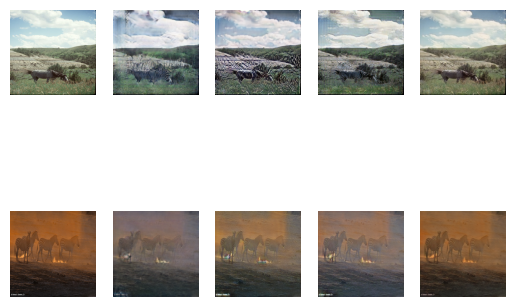

In [152]:
plt.figure()
f, axarr = plt.subplots(2, 5) 

for destination_domain_index, destination_domain in enumerate(['b', 'a']):
    image_name = f'horse2zebra_{"a" if destination_domain=="b" else "b"}_{destination_domain}'
    print('-----')
    print('Classification Confidence Scores (Horse -> Zebra)' if destination_domain=='b' else 'Classification Confidence Scores (Zebra -> Horse)')
    print('-----')
    test_dataloader = DataLoader(
        DomainSet(os.path.join(dataset_path, 'horse2zebra'), train=False, transform=T.ToTensor()),
        batch_size=1,
        shuffle=True,
        num_workers=1
    )
    input_image = next(test_dataloader.__iter__())['image_a' if destination_domain=='b' else 'image_b'].to('cuda')
    save_image(input_image.cpu()[0], f'{image_name}_original.png')
    
    domain_classifier = DomainClassifier('horse2zebra', dataset_path, saved_models_path)
    classification_confidence = domain_classifier.get_confidence(input_image).cpu()[0, 0 if destination_domain=='b' else 1] * 100
    
    print(f"Original Image: {'{:2.2f}'.format(classification_confidence)}%")
    axarr[destination_domain_index][0].imshow(input_image.cpu()[0].permute(1, 2, 0))
    axarr[destination_domain_index][0].axis('off')

    for variation in cycle_gan_variations[:-1]:
        cycle_gan = CycleGAN(variation, dataset_path, saved_models_path)
        generated_image, generator_confidence = cycle_gan.generate(input_image, destination_domain)
        save_image(generated_image, f'{image_name}_{variation["id"]}.png')
        classification_confidence = generator_confidence['image_' + destination_domain] * 100
        print(f"Generated Image (CycleGAN-{variation['id']}): {'{:2.2f}'.format(classification_confidence)}%")
        axarr[destination_domain_index][variation['id'] + 1].imshow(generated_image.permute(1, 2, 0))
        axarr[destination_domain_index][variation['id'] + 1].axis('off')
        cycle_gan.close()
    print('-----')

-----
Classification Confidence Scores (Monet -> Photo)
-----
torch.Size([1, 2])
Original Image: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-4): 100.00%
-----
Classification Confidence Scores (Photo -> Monet)
-----
torch.Size([1, 2])
Original Image: 100.00%


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([1, 2])
Generated Image (CycleGAN-4): 100.00%


<Figure size 640x480 with 0 Axes>

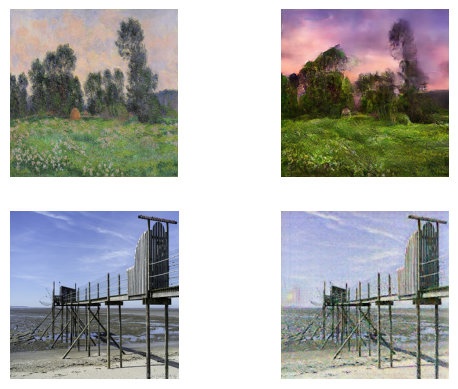

In [128]:
plt.figure()
f, axarr = plt.subplots(2, 2) 

for destination_domain_index, destination_domain in enumerate(['b', 'a']):
    image_name = f'monet2photo_{"a" if destination_domain=="b" else "b"}_{destination_domain}'
    print('-----')
    print('Classification Confidence Scores (Monet -> Photo)' if destination_domain=='b' else 'Classification Confidence Scores (Photo -> Monet)')
    print('-----')
    test_dataloader = DataLoader(
        DomainSet(os.path.join(dataset_path, 'monet2photo'), train=False, transform=T.ToTensor()),
        batch_size=1,
        shuffle=True,
        num_workers=1
    )
    input_image = next(test_dataloader.__iter__())['image_a' if destination_domain=='b' else 'image_b'].to('cuda')
    save_image(input_image.cpu()[0], f'{image_name}_original.png')
    
    domain_classifier = DomainClassifier('monet2photo', dataset_path, saved_models_path)
    classification_confidence = domain_classifier.get_confidence(input_image).cpu()[0, 0 if destination_domain=='b' else 1] * 100
    
    print(f"Original Image: {'{:2.2f}'.format(classification_confidence)}%")
    axarr[destination_domain_index][0].imshow(input_image.cpu()[0].permute(1, 2, 0))
    axarr[destination_domain_index][0].axis('off')

    for variation in cycle_gan_variations[-1:]:
        cycle_gan = CycleGAN(variation, dataset_path, saved_models_path)
        generated_image, generator_confidence = cycle_gan.generate(input_image, destination_domain)
        save_image(generated_image, f'{image_name}_{variation["id"]}.png')
        classification_confidence = generator_confidence['image_' + destination_domain] * 100
        print(f"Generated Image (CycleGAN-{variation['id']}): {'{:2.2f}'.format(classification_confidence)}%")
        axarr[destination_domain_index][variation['id'] - 3].imshow(generated_image.permute(1, 2, 0))
        axarr[destination_domain_index][variation['id'] - 3].axis('off')
        cycle_gan.close()